# Importing initial libraries


In [1]:
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# Downloading and saving data


In [2]:
# Set up yfinance to use pandas data reader
yf.pdr_override()

# Define the list of tickers
tickers = ['COR', 'CE', 'HUM', 'CINF', 'KEYS', 'NXPI', 'BMY', 'EMR',
           'CVS', 'RVTY', 'ES', 'DHI', 'ZBRA', 'KMI', 'INVH', 'GPC', 'SWKS', 'GIS']

# Define the date range
start_date = '2002-01-01'
end_date = '2022-12-31'
Output_file = 'stock_prices.xlsx'

# Create a pandas DataFrame to store the data
price_data = pdr.get_data_yahoo(
    tickers, start=start_date, end=end_date)['Close']
adj_price_data = pdr.get_data_yahoo(
    tickers, start=start_date, end=end_date)['Adj Close']
volume_data = pdr.get_data_yahoo(
    tickers, start=start_date, end=end_date)['Volume']

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed


In [3]:
# Convert the datetime index to string in the format "MM/DD/YYYY"
price_data.index = price_data.index.strftime('%m/%d/%Y')
adj_price_data.index = adj_price_data.index.strftime('%m/%d/%Y')
volume_data.index = volume_data.index.strftime('%m/%d/%Y')

In [4]:

# Create an Excel writer
with pd.ExcelWriter(Output_file, engine='openpyxl') as writer:
    # Save close prices to "Price_daily" sheet
    price_data.to_excel(writer, sheet_name='Price_daily')

    # Save adjusted close prices to "Adj_Price_daily" sheet
    adj_price_data.to_excel(writer, sheet_name='Adj_Price_daily')

    # Save volume data to "Volume_daily" sheet
    volume_data.to_excel(writer, sheet_name='Volume_daily')

print("Stock prices saved to stock_prices.xlsx")

Stock prices saved to stock_prices.xlsx


In [5]:
sp500_data = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)[
    ["Adj Close", "Close", "High", "Low", "Open", "Volume"]]
sp500_data.index = sp500_data.index.strftime('%m/%d/%Y')

with pd.ExcelWriter(Output_file, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    sp500_data.to_excel(writer, sheet_name='S&P 500')
print("Prices for the S&P 500 index (^GSPC) saved to stock_prices.xlsx")

[*********************100%%**********************]  1 of 1 completed
Prices for the S&P 500 index (^GSPC) saved to stock_prices.xlsx


# Calculating Market Captilization


In [6]:
from Support.Market_Cap import cal_market_cap, filter_last_date_per_year

constituents_file = "S&P 500 Constituent.xlsx"
constituents_data = pd.read_excel(
    constituents_file, sheet_name="S&P 500 Constituent")
cal_market_cap(start_date, end_date, constituents_file, Output_file, tickers)


sheet_name = 'Market_Caps'
filtered_df = filter_last_date_per_year(Output_file, sheet_name)


with pd.ExcelWriter(Output_file, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    filtered_df.to_excel(writer, sheet_name='Market_Caps')

print("Annual maket capital saved to stock_prices.xlsx")

Market capitalization data added to the Excel file.
          Date           COR            CE           HUM          CINF  \
0   2002-12-31  2.095853e+09           NaN  1.107811e+09  2.546112e+09   
1   2003-12-31  2.216050e+09           NaN  2.531348e+09  2.904206e+09   
2   2004-12-31  2.272264e+09           NaN  3.289091e+09  3.317502e+09   
3   2005-12-30  3.211912e+09  1.605232e+09  6.018737e+09  3.619250e+09   
4   2006-12-29  3.497818e+09  2.190746e+09  6.127303e+09  3.778133e+09   
5   2007-12-31  3.614503e+09  3.599711e+09  8.342926e+09  3.408416e+09   
6   2008-12-31  2.897552e+09  1.062671e+09  4.129918e+09  2.632865e+09   
7   2009-12-31  4.286256e+09  2.768339e+09  4.862182e+09  2.538390e+09   
8   2010-12-31  5.674673e+09  3.571044e+09  6.064159e+09  3.235818e+09   
9   2011-12-30  6.259214e+09  3.858795e+09  9.793616e+09  3.284150e+09   
10  2012-12-31  7.382484e+09  3.906718e+09  7.777373e+09  4.408009e+09   
11  2013-12-31  1.220708e+10  4.902935e+09  1.184524e+10  6.

# Calculating annual liquidity


##### Calculateing the sum of daily Volume for each firm per year, dividing it by the total shares outstanding, and saving it in the sheet “Liquidity_annual”. This is a measure of how frequently a stock is traded, and generally, it is perceived as a measure of its liquidity.


In [7]:
from Support.liquidity import cal_liquidity
excel_file = "Stock Data Output.xlsx"  # Replace with your file path
sheet_name = "Liquidity_annual"
constituents_data = constituents_data[["ticker", "Name", "Share_outstanding"]]
cal_liquidity(Output_file, tickers, constituents_data, sheet_name)

CE: Data doesn't exist for startDate = 1009861200, endDate = 1041310800
KEYS: Data doesn't exist for startDate = 1009861200, endDate = 1041310800
NXPI: Data doesn't exist for startDate = 1009861200, endDate = 1041310800
KMI: Data doesn't exist for startDate = 1009861200, endDate = 1041310800
INVH: Data doesn't exist for startDate = 1009861200, endDate = 1041310800
CE: Data doesn't exist for startDate = 1041397200, endDate = 1072846800
KEYS: Data doesn't exist for startDate = 1041397200, endDate = 1072846800
NXPI: Data doesn't exist for startDate = 1041397200, endDate = 1072846800
KMI: Data doesn't exist for startDate = 1041397200, endDate = 1072846800
INVH: Data doesn't exist for startDate = 1041397200, endDate = 1072846800
CE: Data doesn't exist for startDate = 1072933200, endDate = 1104469200
KEYS: Data doesn't exist for startDate = 1072933200, endDate = 1104469200
NXPI: Data doesn't exist for startDate = 1072933200, endDate = 1104469200
KMI: Data doesn't exist for startDate = 107293

Liquidity data added to the Excel file.


# Calculating returns


##### Using adjusted close prices at the annual, monthly, and daily frequencies, computing the annual, monthly, and daily returns. Saving them in new sheets labeled “Returns_annual”, “Returns_monthly”, and “Returns_daily”.


In [8]:
def download_data(ticker, start_date, end_date):
    benchmark_symbol = "^GSPC"
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    benchmark_data = yf.download(
        benchmark_symbol, start=start_date, end=end_date)
    return stock_data, benchmark_data


for ticker in tickers:
    data, benchmark_data = download_data(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [9]:
from Support.returns import cal_returns

cal_returns(Output_file, tickers, data)

Data download, Excel file update, and returns calculation completed.


# Calculating annual risks


##### Using Returtns_daily, calculating the standard deviation of each stock in each year. Saving these in a new sheet called “Risk_annual”.


In [10]:
from Support.risk import cal_risks

cal_risks(Output_file, tickers, data)

Data download, Excel file update, returns calculation, and risk calculation completed.


# Calculating statistics


##### Calcuating summary statistics of our portfolio holdings (in sheet “Firm_Summary_Stat”)


In [11]:
import pandas as pd
import numpy as np
from Support.beta import cal_beta_main

# Load the data from Support. Excel file
returns_sheet_name = 'Returns_annual'
constituents_sheet_name = 'S&P 500 Constituent'

returns_data = pd.read_excel(
    Output_file, sheet_name=returns_sheet_name, index_col=0)
constituents_data = pd.read_excel(
    "S&P 500 Constituent.xlsx", sheet_name=constituents_sheet_name, index_col=0)

# Filter returns data for the last 5 years (2018:2022)
returns_data_last_5_years = returns_data.loc['2018-01-01':'2022-12-31']

# Create a new DataFrame for summary statistics
summary_stats_df = pd.DataFrame()


# Calculate and add summary statistics for each firm
summary_stats_df['Min'] = returns_data_last_5_years.min()
summary_stats_df['Max'] = returns_data_last_5_years.max()
summary_stats_df['Mean'] = returns_data_last_5_years.mean()
summary_stats_df['Volatility'] = returns_data_last_5_years.std()

# Load market capitalization data
market_cap_data = pd.read_excel(
    Output_file, sheet_name="Market_Caps", index_col=0)

# Add market capitalization (size) for each firm to the summary_stats_df
# You can use mean() or any other aggregation method
summary_stats_df['Size'] = market_cap_data.mean()


# Add industry information for each firm
summary_stats_df['Industry'] = constituents_data['GICS Sector']

# Add a new sheet "Firm_Summary_Stat" to the existing Excel file
with pd.ExcelWriter(Output_file, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    summary_stats_df.T.to_excel(
        writer, sheet_name="Firm_Summary_Stat", index=True, header=True)


cal_beta_main(tickers, data, benchmark_data, start_date, end_date,
              constituents_file, Output_file, summary_stats_df)

# Personal Portfolio Analysis


##### Strategy = Return: Every January, invest more in firms that had a larger return last year. If they had negative returns, do not invest in them this year.


In [12]:
from Support.portfolio_analysis import cal_portfolio

combined_returns, Rf = cal_portfolio(
    tickers, Output_file)

[*********************100%%**********************]  18 of 18 completed


d:\Projects\Coding Projects\Refined\Financial Modelling-Yahoo Finance\portfolio_analysis.py:29: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_3Factor_All = pdr.get_data_famafrench(
d:\Projects\Coding Projects\Refined\Financial Modelling-Yahoo Finance\portfolio_analysis.py:29: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_3Factor_All = pdr.get_data_famafrench(


Optimization terminated successfully.
         Current function value: -1.342082
         Iterations: 19
         Function evaluations: 468
         Gradient evaluations: 26
[*********************100%%**********************]  1 of 1 completed
Output saved to stock_prices.xlsx


# Calculating portfolio performance


Mean Return: 0.0183
Standard Deviation (in %): 4.4710
Minimum Return (in %): -10.3000
Maximum Return (in %): 13.7000
Alpha: 0.0136
Beta: 0.6478
R-squared: 0.3804
Sharpe Ratio: 0.3874
Treynor Ratio: 0.0267


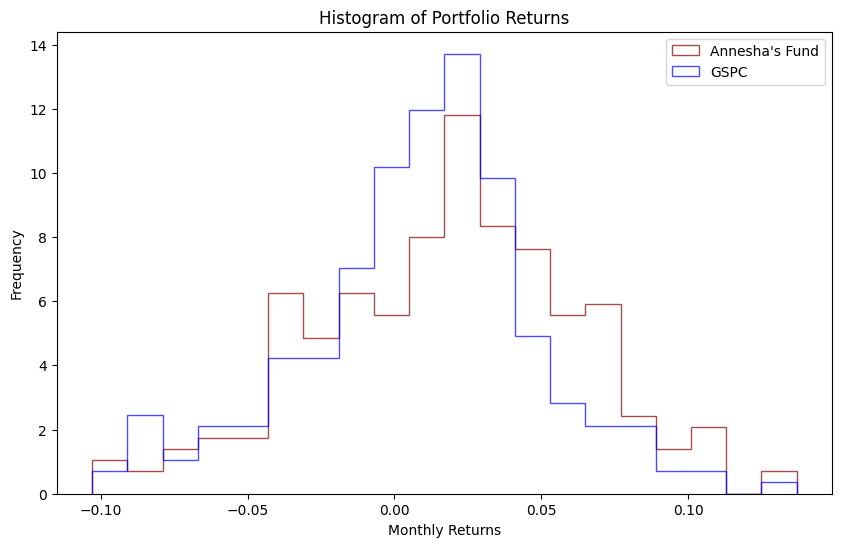

In [13]:
from Support.portfolio_perf import cal_portfolio_perf

cal_portfolio_perf(combined_returns, Rf)

# Calculating Portfolio Returns


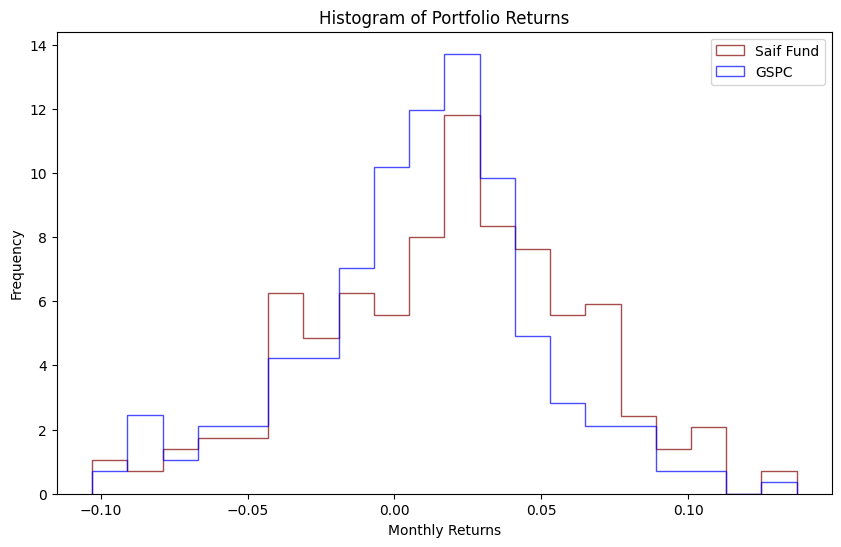

In [15]:
from Support.portfolio_return import cal_portfolio_return

cal_portfolio_return(combined_returns, Rf, Output_file)

# Calculating investment summary


[*********************100%%**********************]  18 of 18 completed
Optimization terminated successfully.
         Current function value: -1.196225
         Iterations: 20
         Function evaluations: 450
         Gradient evaluations: 25
Investments at the end of the sample:
COR     13.88
CE       2.20
HUM     33.88
CINF     4.83
KEYS     9.86
NXPI    11.26
BMY      0.00
EMR      0.00
CVS      0.67
RVTY     0.44
ES       5.63
DHI      1.35
ZBRA     0.00
KMI      0.00
INVH     0.00
GPC      7.19
SWKS     3.30
GIS      5.52
dtype: float64


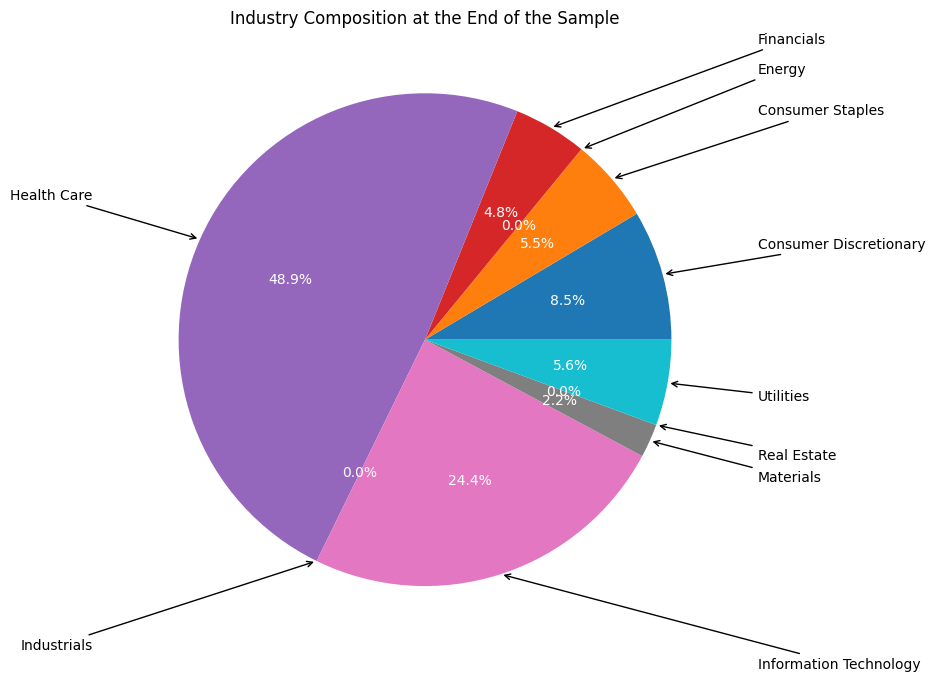

In [16]:
from Support.invest_sum import cal_invest_sum

cal_invest_sum(tickers, Rf, data, constituents_file, Output_file)

# Making excel file more readalbe.

###### (This is the last step)


In [ ]:
import openpyxl
from openpyxl.styles import Alignment, PatternFill

def format_excel(file_path):
    # Load the Excel workbook
    workbook = openpyxl.load_workbook(file_path)

    # Iterate through each sheet in the workbook
    for sheet_name in workbook.sheetnames:
        sheet = workbook[sheet_name]

        # Format text wrapping for all cells
        for row in sheet.iter_rows(min_row=1, max_row=sheet.max_row, min_col=1, max_col=sheet.max_column):
            for cell in row:
                cell.alignment = Alignment(wrap_text=True)

        # Highlight headers with a fill color
        for cell in sheet[1]:
            cell.fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")  # Yellow fill color

    # Save the modified workbook
    workbook.save(file_path)

# Example usage:
excel_file_path = Output_file
format_excel(excel_file_path)